In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

import os
relative_path = "../__Fitting_Drivers/"
absolute_path = os.path.abspath(relative_path)

import sys
import time
import json
from tqdm import tqdm

sys.path.append(absolute_path)

In [2]:
process_data = pd.read_excel('../01_DataCollecting/Sim_result/Heat_exchanger_process_data_result_V5-short.xlsx', index_col=0)
process_data.reset_index(drop=True, inplace=True)

training_data = pd.read_csv('../01_DataCollecting/Sim_result/Surrogate_dataset_LHS_200.csv', index_col=0, encoding='ISO-8859-1')
training_data.reset_index(drop=True, inplace=True)

#direct_calibration = pd.read_excel('../03_Calibration_offline/Results/Direct_sim/Direct_Calibration_result_offline.xlsx', index_col=0)

In [3]:
from CalibrationWorkflow_driver import CalibrationWorkflow

In [4]:
y_fitt = {'PROD1E1IN': {'Weight': 1, 'SDEV':1},
  'PROD1OUT': {'Weight': 1, 'SDEV':1},
  'FEED1E1OUT': {'Weight': 1, 'SDEV':1},
  'FEED1OUT': {'Weight': 1, 'SDEV':1}}

absminfouling = 0.00025
absmaxfouling = 0.002936
# minimum hard limit az optimizernek , 'E1FOULING': (0.00025, 0.002936)
fitparamlimit = {'E1FOULING': {'min':absminfouling, 'max':absmaxfouling}, 'E2FOULING': {'min':absminfouling, 'max':absmaxfouling}}

In [5]:
# Simulation Cols mapping
cols_mapping = {'InputParams': {'FEED1MASSFLOW': 'C3', 'FEED1TEMP': 'C4','PROD1MASSFLOW': 'C5','PROD1TEMP': 'C6',
                          'E1FOULING': 'C11', 'E2FOULING': 'C15'},
               'OutputParams': {'PROD1E1IN': 'C3', 'PROD1OUT': 'C4', 'FEED1E1OUT': 'C7', 'FEED1OUT': 'C8'},
               'Outputuoms': {'PROD1E1IN': 'C', 'PROD1OUT': 'C', 'FEED1E1OUT': 'C', 'FEED1OUT': 'C'}
               }

        # always-one: If direct calibration data exists and is accurate, use that; else use validation data if accurate.
        # always-both: Use both validation and direct calibration data if available and accurate.
        # conditional: Only use direct calibration data if it exists and is accurate.
workflow_settings = {'calibration_type': 'online', # direct, surrogate, online
                     'run_direct_for_not_accurate': True,
                     'stop_workingpoint' : None, # None 
                     'workflow_random_seed': None, # None
                     'debug_workflow': False,
                     'sim_validation_treshold' : 0.1, # None
                     'base_calibration_error_factor': 0.1,
                     'point_selection_type': 'always-one',  # always-one, always-both, conditional
                     'logging_level': 'INFO',  # DEBUG, INFO, WARNING, ERROR, CRITICAL
                     }
calibration_settings = {'y_fitt': y_fitt,
                        'fitparamlimit': fitparamlimit,
                        'particle_num': 20,
                        'optim_iterations': 100,
                        'c1' : 0.1,
                        'c2' : 0.4,
                        'w': 0.7,
                        'stopping_treshold' : 0.0001,
                        'stopping_obj' : 0.1,
                        'optim_debug' : False,
                        }

simulation_model_setting = { 'hy_filename' : '../00_Modell_database/Simulation/SampleModel_V2.hsc',
                            'cols_mapping' : cols_mapping, 
                            'resultindict' : True, 
                            }

surrogate_model_settings = {'load_path' : '../00_Modell_database/Sklearnmodel/sklearnann.joblib'}

online_learning_settings = {'batch_size': 1, 'replay_ratio': 0.025, 'retrain_scaler': False}


In [7]:
# Initialize the calibration workflow with the provided settings and models
workflow = CalibrationWorkflow(process_data, workflow_settings = workflow_settings, calibration_settings=calibration_settings)
workflow.set_simulation_model(simulation_model_setting = simulation_model_setting)
workflow.set_surrogate_model(surrogate_model_settings = surrogate_model_settings)
workflow.init_models()
workflow.init_online_learning(training_data, **online_learning_settings)

[INFO] 14:35:35 - CalibrationWorkflow: Simulation model is initialized, and model loaded from: SampleModel_V2.hsc
[INFO] 14:35:35 - CalibrationWorkflow: Surrogate model is initialized from: ../00_Modell_database/Sklearnmodel/sklearnann.joblib
[INFO] 14:35:35 - CalibrationWorkflow: Online learning initialized with surrogate model and settings : {'batch_size': 1, 'replay_ratio': 0.025, 'retrain_scaler': False}


In [8]:
workflow.run_calibration()

[INFO] 14:35:35 - CalibrationWorkflow: 
[INFO] 14:35:35 - CalibrationWorkflow: STARTING CALIBRATION WORKFLOW.
[INFO] 14:35:35 - CalibrationWorkflow: ============================================================

[INFO] 14:35:35 - CalibrationWorkflow: ----------------------------------------
[INFO] 14:35:35 - CalibrationWorkflow: [PRIMARY-CALIBRATION] Processing sample 0 of 529.
[INFO] 14:35:35 - CalibrationWorkflow: ----------------------------------------
[INFO] 14:35:35 - CalibrationWorkflow: Treshold reached with 27 iteration, best cost: 0.1130751260338699, values: {'FEED1MASSFLOW': 18035.53430133957, 'FEED1TEMP': 25.25656349837262, 'PROD1MASSFLOW': 45159.7172098537, 'PROD1TEMP': 116.5605783388438, 'E1FOULING': 0.00025, 'E2FOULING': 0.000268876831189604}
[INFO] 14:35:35 - CalibrationWorkflow: Working point is NOT accurate enough with cost: 0.450642 > threshold: 0.1
[INFO] 14:35:35 - CalibrationWorkflow: ----------------------------------------
[INFO] 14:35:35 - CalibrationWorkflow: [

In [9]:
workflow.save_results_df('./Results/OnlineLearning/Calibration_result_online_always-one-replay-0.025.xlsx')

[INFO] 14:49:13 - CalibrationWorkflow: Calibration results saved to ./Results/OnlineLearning/Calibration_result_online_always-one-replay-0.025.xlsx


In [10]:
res = workflow.get_results()

In [11]:
resdf = pd.DataFrame(res)

In [12]:
resdf.columns

Index(['SampleID', 'Total_workflow_EllapsedTime', 'Calibration_type',
       'OriginalFactors', 'Target', 'Calibration_Base_Type',
       'Calibration_Base_EllapsedTime', 'Calibration_Base_IterationNum',
       'Calibration_Base_Final_obj', 'Calibration_Base_FinalIO',
       'Calibration_Base_SurrogatePred', 'Validation_Base_SimulationRes',
       'Validation_Base_SimCost', 'Validation_Base_Accurate',
       'Validation_Base_Decision', 'Calibration_Direct_EllapsedTime',
       'Calibration_Direct_IterationNum', 'Calibration_Direct_Final_obj',
       'Calibration_Direct_FinalIO', 'Calibration_Direct_SimCost',
       'Calibration_Direct_Accuracy', 'Calibration_Direct_Decision',
       'OnlineLearning_New_Data', 'OnlineLearning_New_SelectionType',
       'OnlineLearning_New_DataType', 'OnlineLearning_EllapsedTime',
       'OnlineLearning_SelectedReplayids', 'OnlineLearning_SelectedReplayIOs',
       'LocalImprovement', 'GlobalRetention', 'Used_Surrogate_version',
       'New_Surrogate_ver

In [13]:
resdf['Validation_Base_Accurate'].value_counts()

Validation_Base_Accurate
True     496
False     34
Name: count, dtype: int64

In [14]:
resdf['Final_Calibration_Accurate'].value_counts()

Final_Calibration_Accurate
True     529
False      1
Name: count, dtype: int64

In [15]:
workflow_settings['sim_validation_treshold']

0.1

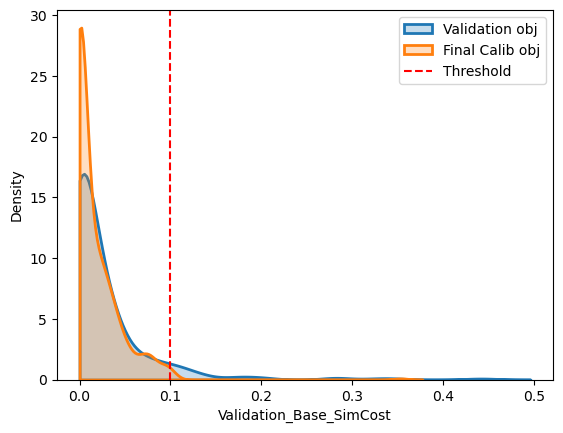

In [16]:
import seaborn as sns

#sns.kdeplot(resdf['Calibration_Base_Final_obj'], label='Surrogate obj',  fill=True, linewidth=2, clip=(0, None))
sns.kdeplot(resdf['Validation_Base_SimCost'], label='Validation obj',  fill=True, linewidth=2, clip=(0, None))
sns.kdeplot(resdf['Final_Calibration_SimCost'], label='Final Calib obj',  fill=True, linewidth=2, clip=(0, None))
plt.axvline(x=workflow_settings['sim_validation_treshold'], color='red', linestyle='--', label='Threshold')
plt.legend()

<Axes: >

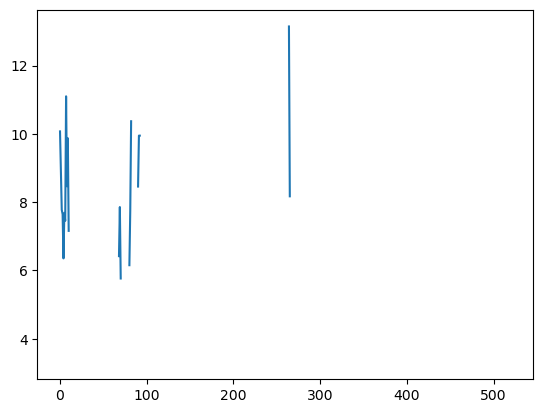

In [17]:
resdf['Calibration_Direct_EllapsedTime'].plot()

In [18]:
resdf['LocalImprovement'].mean()

21.377994520373047

<Axes: >

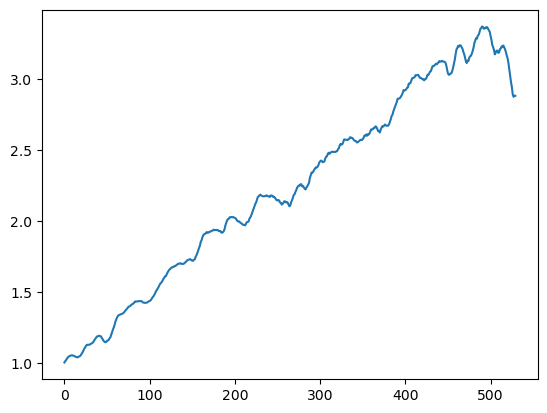

In [19]:
resdf['GlobalRetention'].plot()

In [20]:
resdf

,SampleID,Total_workflow_EllapsedTime,Calibration_type,OriginalFactors,Target,Calibration_Base_Type,Calibration_Base_EllapsedTime,Calibration_Base_IterationNum,Calibration_Base_Final_obj,Calibration_Base_FinalIO,...,OnlineLearning_SelectedReplayids,OnlineLearning_SelectedReplayIOs,LocalImprovement,GlobalRetention,Used_Surrogate_version,New_Surrogate_version,Final_Calibration_Result_IOs,Final_Calibration_SimCost,Final_Calibration_Accurate,Final_Calibration_Type
0,0,11.572942,online,"{'E1FOULING': 0.0003966064602180043, 'E2FOULIN...","{'PROD1E1IN': 108.2722567668642, 'PROD1OUT': 9...",CalibrationType.SURROGATE,0.716769,29,0.113075,"{'FEED1MASSFLOW': 18035.53430133957, 'FEED1TEM...",...,"[33, 187, 165, 82, 61]",None,1.079090,1.006625,base,online_v0,"{'FEED1MASSFLOW': 18035.53430133957, 'FEED1TEM...",6.458805e-06,True,direct
1,1,10.070382,online,"{'E1FOULING': 0.0003858453451426925, 'E2FOULIN...","{'PROD1E1IN': 104.3535050140472, 'PROD1OUT': 9...",CalibrationType.SURROGATE,0.417104,16,0.113680,"{'FEED1MASSFLOW': 17885.82338340906, 'FEED1TEM...",...,"[92, 129, 3, 174, 185]",None,1.093465,1.016081,online_v0,online_v1,"{'FEED1MASSFLOW': 17885.82338340906, 'FEED1TEM...",3.100453e-06,True,direct
2,2,8.650505,online,"{'E1FOULING': 0.0003847697530392205, 'E2FOULIN...","{'PROD1E1IN': 105.9350937121914, 'PROD1OUT': 9...",CalibrationType.SURROGATE,0.163648,6,0.103494,"{'FEED1MASSFLOW': 18346.78716534058, 'FEED1TEM...",...,"[27, 65, 158, 33, 191]",None,1.085603,1.023545,online_v1,online_v2,"{'FEED1MASSFLOW': 18346.78716534058, 'FEED1TEM...",6.170302e-06,True,direct
3,3,9.250102,online,"{'E1FOULING': 0.0004268043194975153, 'E2FOULIN...","{'PROD1E1IN': 106.0854462410004, 'PROD1OUT': 9...",CalibrationType.SURROGATE,0.800931,32,0.071231,"{'FEED1MASSFLOW': 18031.97789720889, 'FEED1TEM...",...,"[154, 101, 95, 62, 118]",None,1.092292,1.034339,online_v2,online_v3,"{'FEED1MASSFLOW': 18031.97789720889, 'FEED1TEM...",5.731123e-07,True,direct
4,4,7.942092,online,"{'E1FOULING': 0.0003682943731335989, 'E2FOULIN...","{'PROD1E1IN': 105.0075133590793, 'PROD1OUT': 9...",CalibrationType.SURROGATE,0.818166,30,0.073287,"{'FEED1MASSFLOW': 18402.51470121294, 'FEED1TEM...",...,"[53, 153, 22, 109, 154]",None,1.118220,1.041909,online_v3,online_v4,"{'FEED1MASSFLOW': 18402.51470121294, 'FEED1TEM...",9.288254e-06,True,direct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,525,1.131608,online,"{'E1FOULING': 0.0004548607687919593, 'E2FOULIN...","{'PROD1E1IN': 116.9302158164906, 'PROD1OUT': 1...",CalibrationType.SURROGATE,0.218074,6,0.007442,"{'FEED1MASSFLOW': 12954.7585825279, 'FEED1TEMP...",...,"[42, 34, 50, 102, 101]",None,496.735332,2.944130,online_v524,online_v525,"{'PROD1E1IN': 117.13021099375351, 'PROD1OUT': ...",1.325839e-02,True,validation
526,526,1.095114,online,"{'E1FOULING': 0.0004822419516333996, 'E2FOULIN...","{'PROD1E1IN': 116.2112946019632, 'PROD1OUT': 1...",CalibrationType.SURROGATE,0.167393,5,0.000009,"{'FEED1MASSFLOW': 12771.85892666417, 'FEED1TEM...",...,"[122, 120, 153, 181, 109]",None,2.862323,2.894550,online_v525,online_v526,"{'PROD1E1IN': 116.17018241554331, 'PROD1OUT': ...",7.877437e-02,True,validation
527,527,1.105916,online,"{'E1FOULING': 0.0004733674673527922, 'E2FOULIN...","{'PROD1E1IN': 116.4229042179647, 'PROD1OUT': 1...",CalibrationType.SURROGATE,0.202892,6,0.000004,"{'FEED1MASSFLOW': 13325.12954876125, 'FEED1TEM...",...,"[48, 8, 173, 171, 69]",None,0.638460,2.877222,online_v526,online_v527,"{'PROD1E1IN': 115.92971174382842, 'PROD1OUT': ...",9.909777e-06,True,validation
528,528,0.986051,online,"{'E1FOULING': 0.0004984942750080559, 'E2FOULIN...","{'PROD1E1IN': 116.8454717819132, 'PROD1OUT': 1...",CalibrationType.SURROGATE,0.067941,2,0.000011,"{'FEED1MASSFLOW': 13512.72411503304, 'FEED1TEM...",...,"[66, 87, 129, 76, 63]",None,0.734728,2.885570,online_v527,online_v528,"{'PROD1E1IN': 117.07613699928714, 'PROD1OUT': ...",7.269947e-03,True,validation
